###  Наименование проекта: "A/B-тестирование"

### Постановка задачи

Провести оценку результатов A/B-теста. 
В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Требуется оценить корректность проведения теста и проанализировать результаты.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    
### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 до 21 декабря 2020 года:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

### План выполнения:

- Загрузка и предварительное изучение данных
- Предобработка данных:
    - преобразование типов,
    - изучение пропусков, дубликатов, коррекция при необходимости и возможности
    - оценка корректности проведения теста:
        - Соответствие данных требованиям технического задания (с проверкой корректности всех пунктов технического задания)
        - Время проведения теста, сопоставление с временем с маркетинговых активностей
        - аудитория теста (проверка на пересечение с конкурирующим тестом и наличие пользователей, участвующих в двух группах теста одновременно)
        - проверка равномерности распределения по тестовым группам и правильность их формирования.
- Исследовательский анализ данных:
    - Количество событий на пользователя и их распределение в выборках
    - распределение числа событий по дням
    - изменение конверсии в воронке в выборках на разных этапах
- Оценка результатов A/B-тестирования
    - проверка статистической разницы долей z-критерием.
- Общие выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Заключение о корректности проведения теста.

## Импорт и предварительное изучение данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as st
import numpy as np
import math as mth
import warnings

In [2]:
#убираем системные предупреждения
warnings.filterwarnings('ignore')
#настраиваем отображение колонок (полностью)
pd.set_option('display.max_columns', None)
#настраиваем отображение формата значений с плавающей точкой
pd.options.display.float_format = '{:,.2f}'.format
#вывод значений без сокращений
pd.set_option('display.max_colwidth', -1)

In [3]:
# загрузка данных
try: #  с локального ресурса
    participants = pd.read_csv('final_ab_participants.csv')
    new_users = pd.read_csv('final_ab_new_users.csv')
    events = pd.read_csv('final_ab_events.csv')
    project_marketing_events = pd.read_csv('ab_project_marketing_events.csv')
except: #  или с сервера Яндекс
    participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
    new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    project_marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')

In [4]:
# изучим датасет participants
print(participants.info())
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [5]:
# изучим датасет new_users
print(new_users.info())
new_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [6]:
# изучим датасет events
print(events.info())
events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [7]:
# изучим датасет project_marketing_events
print(project_marketing_events.info())
project_marketing_events

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


**Вывод**:
- загрузили 4 датасета - с данными: 
    - 1) об участниках тестов 
    - 2) про новых пользователей, зарегистрировавшихся в приложении
    - 3) про события, остуществлённые пользователями в приложении
    - 4) с календарём маркетинговых событий
    
- есть несоответствие типов данных: столбцы с временем в трёх датасетах имеют тип данных `object`, требуется преобразование
- есть пропуски, изучим и при необходимости скорректируем
- дополнительно изучим данные на дубликаты и при необходимости скорректируем

## Предобработка данных

### Функция для изучения датасетов по столбцам

In [8]:
#доп функция для просмотра данных по столбцам датасетов: уникальные значения, тип данных, количество пропусков
def view(data):
    print('Количество пропусков в датасете:', data.isna().sum().sum())
    print('Количество полных дубликатов в датасете', data.duplicated().sum())
    for i in data.columns:
        print('-'*40)
        print(f'Столбец "{i}"')
        print('Тип данных:', data[i].dtypes)
        print('Количество пропусков:', data[i].isna().sum())
        print('Количество локальных дубликатов в столбце', data[i].duplicated().sum())
        print('Уникальные значения:', data[i].value_counts(), sep='\n')
        if data[i].dtypes != 'object':
            print('Минимальное значение:', data[i].min(), 'Максимальное значение:', data[i].max() )

### Обработка датасета `participants`

In [9]:
# изучим датасет по столбцам
view(participants)

Количество пропусков в датасете: 0
Количество полных дубликатов в датасете 0
----------------------------------------
Столбец "user_id"
Тип данных: object
Количество пропусков: 0
Количество локальных дубликатов в столбце 1602
Уникальные значения:
0FDFDA0B2DEC2D91    2
00E68F103C66C1F7    2
BD23AF6242CA944B    2
DD670F7422342729    2
A5E27D8BCACA668E    2
                   ..
A1591805E7D020EE    1
400D3BD0BCB31971    1
D2656A48DD3C4EEE    1
953E74FDE41424B4    1
79F9ABFB029CF724    1
Name: user_id, Length: 16666, dtype: int64
----------------------------------------
Столбец "group"
Тип данных: object
Количество пропусков: 0
Количество локальных дубликатов в столбце 18266
Уникальные значения:
A    9655
B    8613
Name: group, dtype: int64
----------------------------------------
Столбец "ab_test"
Тип данных: object
Количество пропусков: 0
Количество локальных дубликатов в столбце 18266
Уникальные значения:
interface_eu_test          11567
recommender_system_test    6701 
Name: ab_test, d

- В датасете `participants` содержатся сведения об участниках групп A и B для двух разных A/B тестов `interface_eu_test` и интересующего нас (согласно ТЗ) `recommender_system_test`
- При этом в `user_id` имеются дубликаты (1602), можно заключить, что ряд пользователей попали в оба теста
- Имеет смысл отфильтровать интересующий нас диапазон пользователей и создать отдельный датасет, включающий только те `user_id`, которые участвуют в нашем тесте (`our_participants`)
- Объединив (предварительно обработанный) датасет `our_participants` с обработанными датасетами `new_user` и `events`, мы получим датасет для анализа

In [10]:
# выделяем из общего датасета участников в отдельный датасет данные только об участниках нашего теста
our_participants = participants.query('ab_test =="recommender_system_test"').drop(columns = 'ab_test', axis=1)

In [11]:
# изучим датасет по столбцам
view(our_participants)

Количество пропусков в датасете: 0
Количество полных дубликатов в датасете 0
----------------------------------------
Столбец "user_id"
Тип данных: object
Количество пропусков: 0
Количество локальных дубликатов в столбце 0
Уникальные значения:
D1ABA3E2887B6A73    1
B956889B759F3E32    1
7C988DF91F3BA794    1
78D83CDB8DA12901    1
74EF7630CFAC89E8    1
                   ..
A5691EE66CDA977F    1
446CD36FC22A5BB6    1
C37FDEAD2E788A6F    1
1C88591FB981DE87    1
6715343AFBA285AE    1
Name: user_id, Length: 6701, dtype: int64
----------------------------------------
Столбец "group"
Тип данных: object
Количество пропусков: 0
Количество локальных дубликатов в столбце 6699
Уникальные значения:
A    3824
B    2877
Name: group, dtype: int64


### Обработка датасета `new_users`

In [12]:
# откорректируем тип данных в столбце с временем
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

In [13]:
# изучим датасет по столбцам
view(new_users)

Количество пропусков в датасете: 0
Количество полных дубликатов в датасете 0
----------------------------------------
Столбец "user_id"
Тип данных: object
Количество пропусков: 0
Количество локальных дубликатов в столбце 0
Уникальные значения:
D72A72121175D8BE    1
A25EF6D0E025C48E    1
62B9FD1B8BDB669C    1
9A5F371EED469627    1
2DF6B79FC97641EC    1
                   ..
133FDC1180FC743E    1
35F8FFAF240FDB9B    1
C7AAF024F4FF63C5    1
A6EA45CB9FBAB213    1
8F04273BB2860229    1
Name: user_id, Length: 61733, dtype: int64
----------------------------------------
Столбец "first_date"
Тип данных: datetime64[ns]
Количество пропусков: 0
Количество локальных дубликатов в столбце 61716
Уникальные значения:
2020-12-21    6290
2020-12-14    5654
2020-12-07    5595
2020-12-13    4691
2020-12-20    4288
2020-12-12    3963
2020-12-19    3617
2020-12-18    3365
2020-12-08    3239
2020-12-22    3083
2020-12-10    3076
2020-12-17    3048
2020-12-15    3043
2020-12-11    2390
2020-12-23    2180
2020

- В датасете `new_user` содержится информация о зарегистрировавшихся новых пользователях, пропусков и полных дубликатов нет 
- Регион, откуда пришло больше всего регистраций - EU (это хорошо, т.к. в ТЗ имеется указание исследовать поведение пользователей именно из этого региона)
- Диапазон в столбце "first_date" (07-23.12.2020) отличается от заданного в ТЗ периода набора новых пользователей (07-21.12.2020)
- Проверим, попали ли пользователи, зарегистрировавшиеся после 21.12. в наш тест, для чего объединим сформированный ранее  датасет (отфильтрованный по участникам нашего теста) `our_participants` и `new_users` и проверим даты регистрации для нашего теста

In [14]:
# создание контрольного датафрейма для проверки корректности попадания пользователей в тест
control_df = our_participants.merge(new_users, on='user_id', how = 'left')

In [15]:
print('Начало регистрации участников нашего теста:', control_df['first_date'].min())
print('Окончание регистрации участников нашего теста:', control_df['first_date'].max())

Начало регистрации участников нашего теста: 2020-12-07 00:00:00
Окончание регистрации участников нашего теста: 2020-12-21 00:00:00


- убедились, что сведения об участниках нашего теста выгружены из базы в соответствии с ТЗ (начало регистрации 07.12., окончание регистрации 21.12.
- вместе с тем, в датасете содержатся сведения о user_id, не принимавших участие в нашем тесте, с датами регистрации после 21.12.
- эта информация для нашего исследования избыточна, её можно отфильтровать на этом этапе

In [16]:
# фильтруем датасет по временной границе регистрации, заданной в ТЗ
new_users = new_users.query('first_date <= "2020-12-21"')

Чтобы проверить, выполняется ли требование ТЗ об исследовании пользователей из EU, необходимо знать регион, в котором проживают пользователи, отобранные нами в тест, для этого объединим ранее оформленный датасет `our_participants` с `new_users`

In [17]:
# формируем датасет, объединяя данные о взятых в наш тест пользователях и прошедших регистрацию в указанные в ТЗ сроки
our_participants = our_participants.merge(new_users, on='user_id', how='left')

#### Проверка на соответствие условиям ТЗ: число и % пользователей из EU

In [18]:
# подсчёт новых пользователей из EU
EU_new_users = new_users.query('region == "EU"')['region'].count()
#  подсчёт пользователей из EU, отобранных в    
test_EU_users = our_participants.query('region == "EU"')['region'].count()
print(f'Из всего числа новых пользователей из EU ({EU_new_users} чел.) в тест отобрано {test_EU_users} чел., \
т.е. {test_EU_users/EU_new_users * 100}%')

Из всего числа новых пользователей из EU (42340 чел.) в тест отобрано 6351 чел., т.е. 15.0%


Видим, что на этом этапе выполняются требования ТЗ об отборе в тест не менее 15% от зарегистрировавшихся EU пользователей, а также о наличии в обеих группах теста не менее 6000 человек. 

Исходя из требования ТЗ, оставляем в датасете только EU пользователей

In [19]:
# фильтр датасета по заданным в ТЗ условиям (пользователи только из EU)
our_participants = our_participants.query('region == "EU"')

#### Оценка количества и влияния id, участвующих в параллельном тесте

Теперь оценим влияние на наш тест (`recommender_system_test`) user_id, попавших одновременно и в другой тест (`interface_eu_test`)\
Для этого создадим дополнительные series:
- список id пользователей, попавших в группу A теста `interface_eu_test` (для которых, фактически, не производилось никаких действий/изменений, отличающихся от тех, что были у "наших" пользователей, и, как следствие, с т.з. поведения в "нашем" тесте они ничем не отличаются от "наших" пользователей, не задействованных в параллельном тесте)
- список id пользователей, попавших в группу B теста `interface_eu_test` (на действия которых теоретически мог повлиять другой тест, т.к. судя по названию, там мог быть изменён интерфейс, что, в свою очередь могло бы повлиять на действия уже в рамках нашего теста)

In [20]:
# формируем датасет из пользователей группы A параллельного теста
A_interface_user = participants.query('group == "A" and ab_test == "interface_eu_test"').drop(columns='group', axis=1)

In [21]:
# формируем датасет из пользователей группы B параллельного теста
B_interface_user = participants.query('group == "B" and ab_test == "interface_eu_test"').drop(columns='group', axis=1)

In [22]:
# рассчитываем, сколько A/B - пользователей параллельного теста также попали в число участников нашего теста
userA = our_participants.query('user_id in @A_interface_user.user_id')['user_id'].count()
userB = our_participants.query('user_id in @B_interface_user.user_id')['user_id'].count()
print(f'В нашем тесте {userA} ({round(userA / our_participants.shape[0] * 100,1)}%) участников из группы А и \
{userB} ({round(userB / our_participants.shape[0] * 100,1)}%) участника из группы B параллельного теста')

В нашем тесте 819 (12.9%) участников из группы А и 783 (12.3%) участника из группы B параллельного теста


- Как отмечалось выше, наличие в нашем тесте участников из группы А параллельного теста никак не повлияет на результаты нашего теста, такое влияние может быть только при включении в тест участников группы B параллельного теста
- при этом число вторых (783 человека, более 12% от общего числа участников нашего теста ) слишком велико, чтобы просто удалить их, т.к. будут нарушены требования ТЗ к числу участников (от 6000) и % участников из EU (не менее 15%)
- попробуем оценить распределение "B_участников" параллельного теста по группам нашего теста, для чего объединим датафреймы `our_participants` и `B_interface_user`

In [23]:
# объединение датасетов с "нашими" участниками и участниками группы B параллельного теста
our_participants = our_participants.merge(B_interface_user, on='user_id', how='left')

In [24]:
# расчёт распределения участников группы B параллельного теста  - по группам A и B нашего теста
test_inA = our_participants.groupby('group')['ab_test'].count()[0] / our_participants.groupby('group')['group'].count()[0]
test_inB = our_participants.groupby('group')['ab_test'].count()[1] / our_participants.groupby('group')['group'].count()[1]
print(f'Участники группы B паралелльного теста составляют \
для группы А: {round(test_inA *100,1)}% группы, для группы B: {round(test_inB *100,1)}% группы')

Участники группы B паралелльного теста составляют для группы А: 12.1% группы, для группы B: 12.7% группы


- замечаем схожее процентное распределение участников группы B параллельного теста по группам  изучаемого теста, из чего можно предположить и схожее влияние действий таких участников на результаты теста

Решение: оставляем в нашем тесте user_id, занятые в паралелльном тесте: из группы А (как не подвергшихся влиянию каких-либо доп. изменений по сравнению с участниками нашего теста) и из группы B (так как они схожим образом распределены в тестовой и контрольной группах нашего теста и можно считать, что влияние на них условий параллельного теста схожим образом отразится на действиях в рамках нашего теста для обеих групп)

*Удалим не нужные теперь столбцы `ab_test` и `region` из датафрейма с участниками нашего теста*

In [25]:
our_participants.drop(columns=['ab_test', 'region'], axis=1, inplace=True)

#### Проверка id пользователей на попадание в обе группы (A и B) теста

In [26]:
our_participants.groupby('user_id')['group'].nunique().reset_index().query('group > 1').count()

user_id    0
group      0
dtype: int64

В результате создан датафрейм `our_participants` с уникальными id пользователей, распределёнными по двум группам A/B теста `recommender_system_test`, пропусков, нулей и дубликатов нет

### Обработка датасета `events`

In [27]:
# откорректируем тип данных в столбце с временем
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [28]:
# изучим датасет по столбцам
view(events)

Количество пропусков в датасете: 377577
Количество полных дубликатов в датасете 0
----------------------------------------
Столбец "user_id"
Тип данных: object
Количество пропусков: 0
Количество локальных дубликатов в столбце 381614
Уникальные значения:
A3917F81482141F2    36
D6477068EF132236    32
8AEB716C4CD82CA7    32
590DACD07A839BC3    32
3356239C0DC75E2A    32
                    ..
B80297D6570EA5FE    1 
D2656A48DD3C4EEE    1 
83E9CFC64D61108E    1 
30C9930817226A34    1 
F7DC611E716A9F76    1 
Name: user_id, Length: 58703, dtype: int64
----------------------------------------
Столбец "event_dt"
Тип данных: datetime64[ns]
Количество пропусков: 0
Количество локальных дубликатов в столбце 173049
Уникальные значения:
2020-12-23 02:37:24    10
2020-12-14 18:54:55    10
2020-12-20 02:51:18    9 
2020-12-24 00:54:52    9 
2020-12-13 06:00:54    9 
                      .. 
2020-12-18 10:54:12    1 
2020-12-18 19:31:57    1 
2020-12-18 09:04:49    1 
2020-12-18 16:53:52    1 
2020-12-3

- в датасете `events` описаны события, произошедшие с пользователями в системе с начала 07.12.2020 до  до конца 30.12.2020
- получается, что для ряда новых пользователей (с датой регистрации > 16.12.2020) не выполнится условие ТЗ, о наблюдении в течение 14 дней (т.е. мы увидим для них не полный лайфтайм)
- возможно, что интересующие нас в исследовании действия (события) с ними за этот период (9-13 дней) происходили, и неоднократно, так что сохраним эти данные и изучим распределение событий по lifetime на этапе числового анализа
- типов событий ("event_name") четыре:
     - login: авторизация
     - product_page: просмотр страниц(ы) товара
     - purchase: размещение заказа
     - product_cart: ввод данных карты(?)
- в столбце "details" датасета содержится информация о стоимости заказа (это будет важно при расчёте изменения `purchase` в течение тестирования)

#### Формирование датасета для анализа (с участниками теста и событиями)

In [29]:
# объединим ранее сформированный датасет с участниками `our_participants` и события `events`
data = our_participants.merge(events, on='user_id', how='left')

*Добавим в датасет служебный столбец `lifetime`, показывающий, на какой день после регистрации пользователь осуществил то или иное событие*

In [30]:
data['lifetime'] = (data['event_dt'] - data['first_date']).dt.days

In [31]:
# изучим объединённый датасет
view(data)

Количество пропусков в датасете: 31704
Количество полных дубликатов в датасете 0
----------------------------------------
Столбец "user_id"
Тип данных: object
Количество пропусков: 0
Количество локальных дубликатов в столбце 19939
Уникальные значения:
1198061F6AF34B7B    28
115EBC1CA027854A    27
CED71698585A2E46    24
1BFEE479308EFF44    24
89545C7F903DBA34    21
                    ..
27D8287BE2BDD495    1 
490E84A1AE8B752A    1 
D3F219FA0FE3AC6F    1 
E2FE85B51F8E74D1    1 
187957958A06BEF6    1 
Name: user_id, Length: 6351, dtype: int64
----------------------------------------
Столбец "group"
Тип данных: object
Количество пропусков: 0
Количество локальных дубликатов в столбце 26288
Уникальные значения:
A    19339
B    6951 
Name: group, dtype: int64
----------------------------------------
Столбец "first_date"
Тип данных: datetime64[ns]
Количество пропусков: 0
Количество локальных дубликатов в столбце 26275
Уникальные значения:
2020-12-14    3481
2020-12-21    3221
2020-12-07    26

Для итогового датасета:
- в столбце `lifetime` для ряда пользователей значения превышают заданные в ТЗ 14 дней. Чтобы изучать действия пользователей согласно ТЗ, необходимо предварительно отфильтровать строки с информацией о действиях, совершённых вне пределов lifetime
- в столбцах `event_name` и `event_dt` (как результат, и в `lifetime`) появились пропуски (2870 в каждом), очевидно, речь идёт о том, что некотороое количество user_id никаких действий (после регистрации) в воронке продаж не совершали. Т.к. в рамках проекта нас интересует изучение действий пользователей после регистрации, эти строки, не несущие полезной информации, можно отфильтровать. Тем самым наш итоговый датасет сократится ниже означенных в ТЗ параметров (6000 уникальных пользователей), но вариантов дополнить пропущенную информацию у нас на этом этапе уже нет
- имеются многочисленные пропуски в столбце `details`, согласно описанию данных в этом столбце указан размер оплаты (в случае, когда пользователь совершил событие "purchase"). Разумеется, для всех остальных типов событий данных в столбце и не должно быть. Удалять пропуски мы не будем, но проверим, соответствует ли число непустых значений в столбце `details` количеству событий "purchase" в столбце `event_name`

In [32]:
# фильтруем датасет на lifetime в пределах 14 дней и на отсутствие NAN в столбце event_name
data = data.query('lifetime <= 14').query('event_name.notna()')

In [33]:
# проверим число оставшихся уникальных ID
print(f'В итоговом датасете осталось {data.user_id.nunique()} пользователей, совершавших действия в воронке продаж')
print(f'Это {round(data.user_id.nunique() / test_EU_users * 100,2)}% от количества и \
{round(data.user_id.nunique() / EU_new_users * 100,2)}% от числа пользователей из EU, требуемых в ТЗ')

В итоговом датасете осталось 3481 пользователей, совершавших действия в воронке продаж
Это 54.81% от количества и 8.22% от числа пользователей из EU, требуемых в ТЗ


In [34]:
# проверка на число и соответствие оплат событию "purchase"
print('Число событий "purchase" в датасете:', data[data['event_name'] == "purchase"]['event_name'].count())
print('Количество оплат в датасете:', data['details'].value_counts().sum())
print('Нет оплаты (для действия "purchase"):', data.query('event_name == "purchase" and details.isna()')['details'].count())

Число событий "purchase" в датасете: 3123
Количество оплат в датасете: 3123
Нет оплаты (для действия "purchase"): 0


### Обработка датасета `project_marketing_events`

In [35]:
# откорректируем тип данных в столбцах с временем
project_marketing_events[['start_dt', 'finish_dt']] = \
project_marketing_events[['start_dt', 'finish_dt']].apply(pd.to_datetime)

In [36]:
# изучим датасет по столбцам
view(project_marketing_events)

Количество пропусков в датасете: 0
Количество полных дубликатов в датасете 0
----------------------------------------
Столбец "name"
Тип данных: object
Количество пропусков: 0
Количество локальных дубликатов в столбце 0
Уникальные значения:
Christmas&New Year Promo            1
St. Valentine's Day Giveaway        1
St. Patric's Day Promo              1
Easter Promo                        1
4th of July Promo                   1
Black Friday Ads Campaign           1
Chinese New Year Promo              1
Labor day (May 1st) Ads Campaign    1
International Women's Day Promo     1
Victory Day CIS (May 9th) Event     1
CIS New Year Gift Lottery           1
Dragon Boat Festival Giveaway       1
Single's Day Gift Promo             1
Chinese Moon Festival               1
Name: name, dtype: int64
----------------------------------------
Столбец "regions"
Тип данных: object
Количество пропусков: 0
Количество локальных дубликатов в столбце 8
Уникальные значения:
APAC                        4
EU, C

In [37]:
project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


В датасете `project_marketing_events` содержится график проведения маркетинговых акций, которые, в случае проведения для региона тестирования (EU) и синхронно с нашим тестом, могли оказать влияние на поведение участников тестирования.
Отфильтруем датасет на события:
- Которые проводились для региона EU, при этом:
    - Начались до периода, закончились во время или
    - Начались до периода, закончились после или
    - Начались во время периода, закончились во время периода или
    - Начались во время периода, закончились после\
(все последние утверждения можно свести к двум условиям: марк. акция началась до конца теста и закончилась после начала теста)

In [38]:
# фильтр датасета с маркетинговыми событиями
project_marketing_events.query('regions.str.contains("EU") and (start_dt <= @data.event_dt.max() and finish_dt >= @data.event_dt.min())')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Такое событие только одно, `Christmas&New Year Promo`, при анализе распределения событий по датам изучим, повлияла ли (и каким образом) эта акция на поведение участников теста

**Выводы**
- коррекция, фильтрация и проверка дубликатов  произведены для всех полученных датасетов
- по итогу сформирован датасет для анализа, содержащий описание пользователей из региона EU, а также событий, осуществлённых этими пользователями в течение периода тестирования
- в датасете присутствуют только уникальные id, но их количество не соответствует требованиям ТЗ (т.к. при отборе и распределении по группам участников теста не учитывалось совершение пользователями действия в рамках воронки продаж, а только факт регистрации в сроки, указанные в ТЗ)

Проанализируем имеющиеся данные

## Исследовательский анализ

### Анализ событий

#### Число событий в логе

Выясним:
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?

In [39]:
display(f'Всего в логе {data.event_name.notna().sum()} событий')
display(f"Всего в логе {data['user_id'].nunique()} пользователь")
display(f"В среднем на одного пользователя приходится {round(data.event_name.notna().sum()/data['user_id'].nunique(),2)} события")

'Всего в логе 22828 событий'

'Всего в логе 3481 пользователь'

'В среднем на одного пользователя приходится 6.56 события'

Перейдём к изучению числа событий по группам теста (выборкам)

#### Число событий на пользователя (по группам теста)

In [40]:
# создадим на базе основного датасета выборки по группам теста A и B
dataA = data.query('group == "A"')
dataB = data.query('group == "B"')

In [41]:
# создаём сводные таблицы, в которой рассчитаем число событий для каждого user_id для каждой выборки
data_qty_A = dataA.pivot_table(index = 'user_id', values = 'event_name', aggfunc='count').reset_index()
data_qty_B = dataB.pivot_table(index = 'user_id', values = 'event_name', aggfunc='count').reset_index()

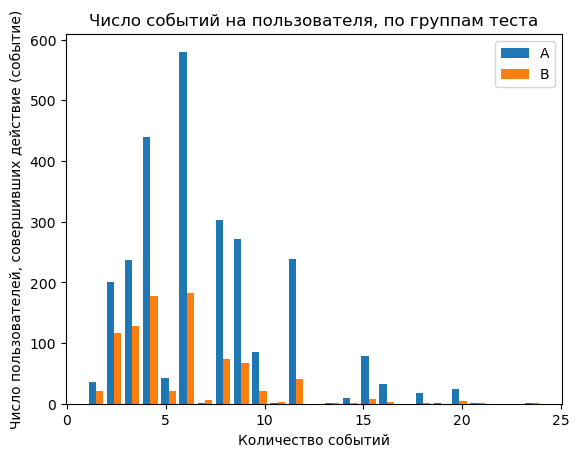

In [42]:
# построим гистограмму распределения числа событий на каждого пользователя
plt.hist([data_qty_A['event_name'], data_qty_B['event_name']], bins=25, label=['A', 'B']);
plt.xlabel('Количество событий')
plt.ylabel('Число пользователей, совершивших действие (событие)')
plt.title('Число событий на пользователя, по группам теста')
plt.legend(loc='upper right')
plt.show()

In [43]:
# изучим численные показатели количества событий, приходящихся на каждого пользователя в выборках, метод describe()
display('Группа A:', data_qty_A['event_name'].describe())
display('Группа B:', data_qty_B['event_name'].describe())

'Группа A:'

count   2,604.00
mean    6.90    
std     3.84    
min     1.00    
25%     4.00    
50%     6.00    
75%     9.00    
max     24.00   
Name: event_name, dtype: float64

'Группа B:'

count   877.00
mean    5.53  
std     3.31  
min     1.00  
25%     3.00  
50%     4.00  
75%     8.00  
max     24.00 
Name: event_name, dtype: float64

- события неодинаково происходят в контрольной (группа A) и тестовой группах (группа B): общее, медианное и среднее число событий на пользователя больше в группе A
- максимальное число событий - 24 (6 циклов по 4 события) вполне укладывается в рамки допустимого - 6 полных циклов покупки за 14 дней

#### Распределение событий по дням lifetime (по группам теста)

In [44]:
#  рассчитаем число событий на пользователя в день lifetime для обеих групп, контрольной и тестовой
dataA_by_lifetime = dataA.groupby('lifetime')['event_name'].count().div(dataA['user_id'].nunique())

dataB_by_lifetime = dataB.groupby('lifetime')['event_name'].count().div(dataB['user_id'].nunique())

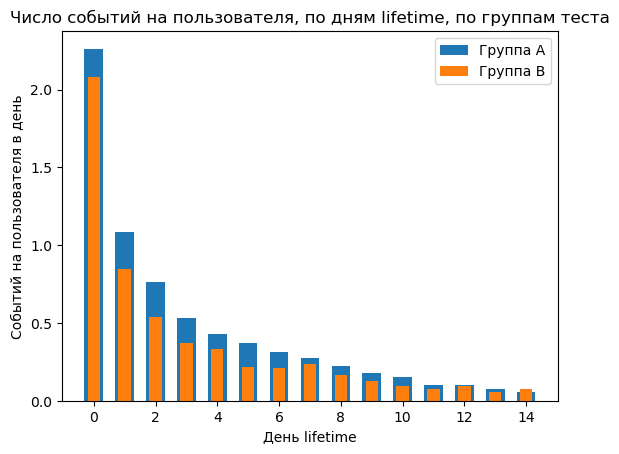

In [45]:
# построим распределение событий на пользователя по дням lifetime, по группам теста
plt.bar(x = dataA_by_lifetime.index, height = dataA_by_lifetime, width = 0.6);
plt.bar(x = dataB_by_lifetime.index, height = dataB_by_lifetime, width = 0.4);
plt.xlabel('День lifetime')
plt.ylabel('Событий на пользователя в день')
plt.title('Число событий на пользователя, по дням lifetime, по группам теста')
plt.legend(['Группа A', 'Группа B'], loc='upper right')
plt.show()

- видим, что для обеих групп основная часть событий происходит в первые дни lifetime
- пользователи тестовой группы по сравнению с контрольной группой совершали меньше действий (событий) в день на протяжении всего lifetime, кроме 12 и 14 дня (но там число событий на пользователя слишком незначительно, чтобы можно было говорить о каком-либо "переломе в поведении тестовой группы по сравнению с контрольной")

In [46]:
#  рассчитаем число событий на пользователя по дням теста для обеих групп
dataA_by_calendar = dataA.groupby(dataA['event_dt'].dt.date)['event_name'].count().div(dataA['user_id'].nunique())
dataB_by_calendar = dataB.groupby(dataB['event_dt'].dt.date)['event_name'].count().div(dataB['user_id'].nunique())

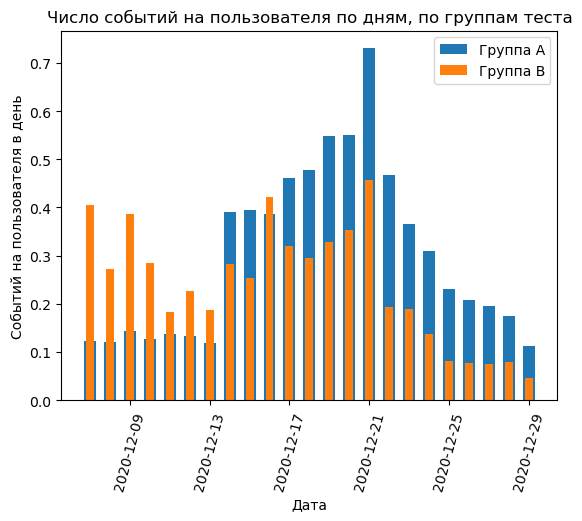

In [47]:
# построим распределение событий на пользователя по дням теста, по группам теста
plt.bar(x = dataA_by_calendar.index, height = dataA_by_calendar, width = 0.6);
plt.bar(x = dataB_by_calendar.index, height = dataB_by_calendar, width = 0.4);
plt.xlabel('Дата')
plt.xticks(rotation = 75)
plt.ylabel('Событий на пользователя в день')
plt.title('Число событий на пользователя по дням, по группам теста')
plt.legend(['Группа A', 'Группа B'], loc='upper right')
plt.show()

- число событий по календарным дням по группам распределено неравномерно:
     - в группе А число событий примерно на одном уровне с 7 до 14.12, потом скачок и плавный рост с пиком 21.12, после чего заметный провал и плавное снижение вплоть до 30.12 (последнего дня в датасете с данными по событиям)
     - в группе B график с 7 до 21.12 имеет более "синусообразную" форму, с пиками и снижениями, без скачков, на 21.12 также приходится максимальное число событий, после этого просадка и плавное снижение
- число событий на пользователя в тестовой группе превышает значения в контрольной группе в течение первой недели тестирования, затем (после 13.12.) ситуация меняется на противоположную (за счёт роста числа событий на пользователя в контрольной группе)
- похоже, что проведение маркетинговой акции с 25.12. явного влияния на число событий не оказало, не изменив сложившиеся к тому моменту тенденции (плавное, день ото дня, уменьшение числа событий) в обеих группах теста

### Число регистраций по дням, по группам теста

In [48]:
# расчёт числа регистраций для обеих групп теста
reg_by_day_A = dataA.pivot_table(index = 'first_date', values = 'user_id', aggfunc = 'nunique').reset_index()
reg_by_day_B = dataB.pivot_table(index = 'first_date', values = 'user_id', aggfunc = 'nunique').reset_index()

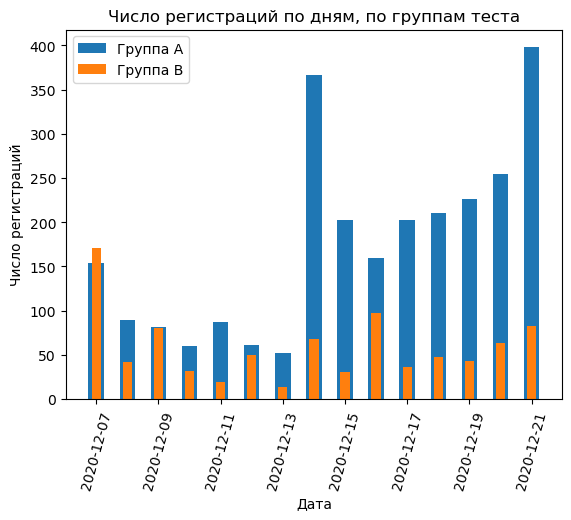

In [49]:
# построение числа регистраций по лням для обеих групп теста
plt.bar(x = reg_by_day_A['first_date'], height = reg_by_day_A['user_id'], width=0.5, label = 'Группа A');
plt.bar(x = reg_by_day_B['first_date'], height = reg_by_day_B['user_id'], width=0.3, label = 'Группа B')
plt.xlabel('Дата')
plt.ylabel('Число регистраций')
plt.title('Число регистраций по дням, по группам теста')
plt.legend(loc='upper left')
plt.xticks(rotation = 75)
plt.show()

**Вывод**
- наблюдаем характерный "календарный" принцип регистрации в обеих группах, с пиками по понедельникам (7, 14 и 21 декабря), спадом во вторник и плавным нарастанием к выходным
- существенных отличий в характере регистраций между группами теста не наблюдается (с учётом итогового количества пользователей в выборках), с этой точки зрения пользователи равномерно распределены по выборкам

### Число действий для различных типов устройств, по группам теста

In [50]:
# формируем служебные массивы (число действий с различных типов устройств по группам теста)
device_A = data.groupby('device')['device'].count().div(dataA['user_id'].nunique())
device_B = dataB.groupby('device')['device'].count().div(dataB['user_id'].nunique())

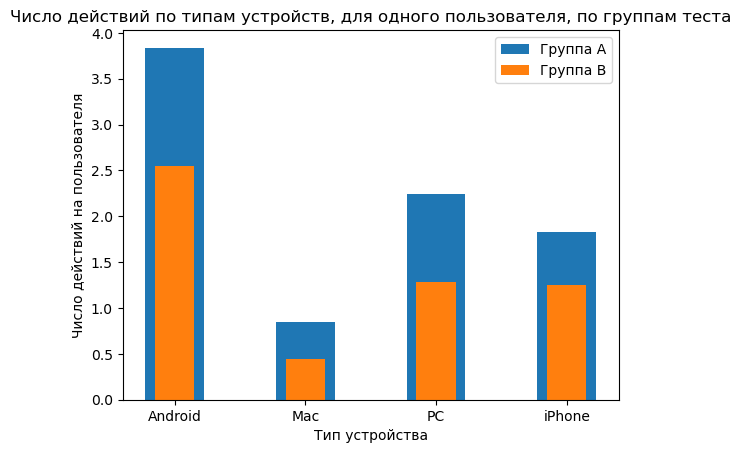

In [51]:
plt.bar(x = device_A.index, height = device_A, width=0.45, label = 'Группа A');
plt.bar(x = device_B.index, height = device_B, width=0.3, label = 'Группа B')
plt.xlabel('Тип устройства')
plt.ylabel('Число действий на пользователя')
plt.title('Число действий по типам устройств, для одного пользователя, по группам теста')
plt.legend(loc='upper right')
plt.show()

**Вывод**:
- соотношение использования разных типов устройств близки для обеих групп: 
    - на первом месте Android,
    - далее, с отставанием по числу действий почти в 2 раза PC, ещё ниже - iPhone
    - в самом конце (по числу действий), в разы меньше всех других типов  - Mac
- число действий на пользователя для всех типов устройств в группе А примерно в 1.5 раза превышает таковое для группы B
- заметная (по сравнению с группой B) активность (по числу действий) пользователей группы A в приложении может быть объяснена двумя взаимоисключающими вариантами:
     - обновлённая версия приложения, предложенная группе B, настолько неудачна, что приводит к резкому сокращению действий в ней (неудачный интерфейс воронки, часто неспровоцированное разлогинивание и т.п.)
     - версия приложения для группы B настолько хорошо оптимизирована, что кратно, в разы, сокращает число действий внутри системы для достижения устраивающего пользователя результата (просмотр карточки товара, оформление покупки и т.д.)
- посмотрим, как число действий сказывается на конечном результате, изучим, чему равен средний чек по группам теста

### Средний чек покупки по группам теста

In [52]:
number = 0
for i in [dataA, dataB]:
    print(f'Для группы {"A:" if number == 0 else "B:"}')
    print(f'Сумма всех покупок: {round(i.details.sum(), 2)}')
    print(f'Средний чек одной покупки: {round(i.details.sum() / i[i.details.notna()].details.count(), 2)}')
    print(f'Средний чек на участника группы {round(i.details.sum() / i.user_id.nunique(), 2)}')
    print()
    number += 1

Для группы A:
Сумма всех покупок: 57705.01
Средний чек одной покупки: 23.09
Средний чек на участника группы 22.16

Для группы B:
Сумма всех покупок: 14268.76
Средний чек одной покупки: 22.87
Средний чек на участника группы 16.27



- сумма покупок в тестовой группе (B) в 4 раза меньше, чем в контрольной (A)
- с учётом разницы в размерах групп, средний чек на уникального покупателя из группы A в 3 раза выше, чем для группы B
- уже на этом этапе можно заключить, что ожидаемый эффект в покупках не достигнут, происходит снижение по всем показателям: размер среднего чека по группе и размер среднего чека на одного покупателя

###  Анализ воронки

#### Расчёт частоты событий (по группам теста)

In [53]:
number = 0
for i in [dataA, dataB]:
    print(f'Для группы {"A:" if number == 0 else "B:"}')
    print(i.groupby(by='event_name').agg({'event_dt': 'count'}).rename(columns=({'event_dt': 'qty'})).
          sort_values(by='qty', ascending=False))
    print()
    number += 1

Для группы A:
               qty
event_name        
login         7968
product_page  5125
purchase      2499
product_cart  2385

Для группы B:
               qty
event_name        
login         2345
product_page  1257
product_cart  625 
purchase      624 



- всего в логе есть 4 типа событий, для обеих выборок по мере уменьшения частоты встречаемости это:\
    `login` - авторизация в программе\
    `product_page` - изучение страницы продуктов\
    `purchase` - подтверждение (оплата?) заказа\
    `product_cart` - изучение карточки (характеристик) определённого продукта
- видно, что для обеих групп число просмотров карточек товара меньше числа размещённых заказов, что указывает на возможность осуществить в программе заказ, минуя этап просмотра карточки товара

#### Расчёт числа пользователей и конверсии для каждого из видов событий (по группам теста)

In [54]:
# сгруппируем датафрейм по событиям (в разрезе по группам эксперимента)
funnel_exp = data.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')

Данные сгруппированы по наименованию этапа, сгруппируем их по логике, соответствующей естественному процессу покупки: логин - просмотр страницы товаров - просмотр карточки товара - покупка

In [55]:
#  реиндексация массива данных для воронки в соответствии с логикой прохождения событий
funnel_exp = funnel_exp.reindex(['login','product_page','product_cart','purchase'])

#### Построение воронки

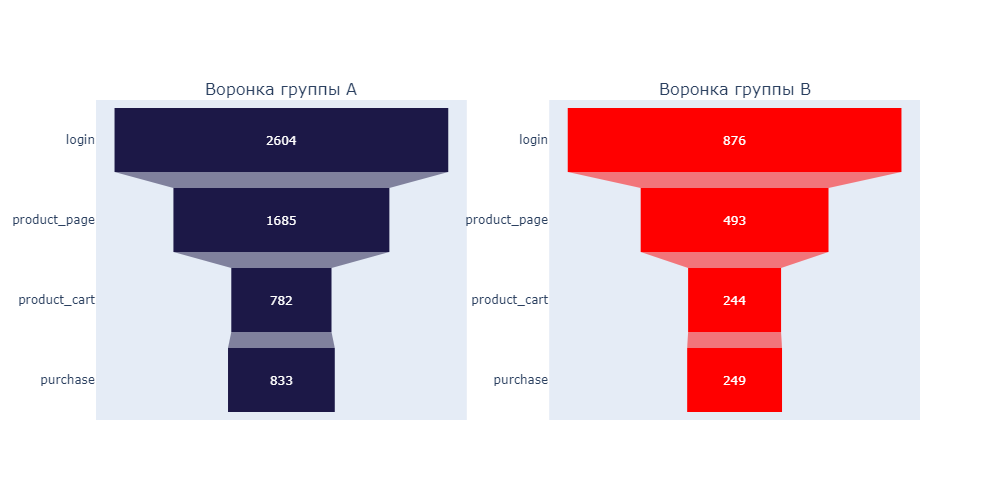

In [56]:
fig = make_subplots(rows=1, cols=2,subplot_titles=("Воронка группы A","Воронка группы B"))

fig.add_trace(go.Funnel(y = funnel_exp.index, x = funnel_exp['A'],
    textposition = "inside", textinfo = "value", hoverinfo = "y + percent previous + percent initial",
    marker = {"color": "#1c1847"}), row=1, col=1)

fig.add_trace(go.Funnel(y = funnel_exp.index, x = funnel_exp['B'],
        textposition = "inside", textinfo = "value", hoverinfo = "y + percent previous + percent initial", 
        marker = {"color": "#ff0000"}), row=1, col=2)

fig.update_layout(showlegend=False,height=500, width=1000)
fig.show('png')

**Выводы**:
- видно, что для обеих групп число просмотров карточек товара меньше числа размещённых заказов, что указывает на возможность осуществить в программе заказ, минуя этап просмотра карточки товара
- проверим выполнение ожидаемых эффектов:
     - конверсии в просмотр карточек товаров — событие `product_page` - 64.7% от предыдущего шага для контрольной группы и  56.3% для тестовой => ПРОИЗОШЛО УХУДШЕНИЕ,
     - просмотры корзины — `product_cart` - 46.4% от предыдущего шага для контрольной группы и  49.5% для тестовой => произошло улучшение, но ОЖИДАЕМЫЙ ЭФФЕКТ (УЛУЧШЕНИЕ НА 10%) НЕ ДОСТИГНУТ

## Статистический анализ

Применим для групп A/B анализа z-тест на равенство долей. \
Коэффициент статистической значимости примем равным 0.05

Для проведения теста мы 
1) сформулируем гипотезы:

**Нулевая гипотеза H0**: различия между группами статистически незначимы\
**Альтернативная гипотеза H1**: различия между группами статистически значимы

2) создадим функцию для проведения z-теста для проверки гипотезы о равенстве долей выборок A и B, где:

`alpha` - уровень статистической значимости,\
`event` - событие, на уровне которого мы проверяем равенство долей

In [57]:
def z_test(event, alpha):
# уровень статистической значимости
    alpha = alpha
    event = str(event)
      
# число успешных переходов на уровень в группе A
    successes_1 = funnel_exp.loc[event, 'A']
# число успешных переходов на уровень в группе B
    successes_2 = funnel_exp.loc[event, 'B']
# число участников в группе A
    trials_1 = dataA['user_id'].nunique()
# число участников в группе B
    trials_2 = dataB['user_id'].nunique()

# пропорция успехов в группе A:
    p1 = successes_1/trials_1
# пропорция успехов в группе B:
    p2 = successes_2/trials_2
       
# пропорция успехов в комбинированном датасете:
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)
# разница пропорций в датасетах
    difference = p1 - p2 
# статистика в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    res = ['A', 'B', event, p_value]
    
    if p_value < alpha:
        res.append('отвергаем H0, различия между группами статистически значимы')
    else:
        res.append('не отвергаем H0, различия между группами статистически незначимы')
    return res

При выполнении проверок гипотезы, есть шанс совершить ошибки первого и второго рода:
 - отвергнуть нулевую гипотезу, когда она на самом деле верна, т.н. "ложноположительный" результат теста,
 - не отвергнуть неверную нулевую гипотезу, когда она неверна, т.н. "ложноотрицательный" результат теста
 
При проведении проверки одной гипотезы частота ошибок типа I равна уровню значимости (α), который ранее положили выбрать = 0,05. 

Однако в проектном задании мы проведём несколько проверок гипотез (4, по числу шагов процесса покупки), в таком случае уровень значимости рекомендуется выбирать с учётом критерия Бонферрони, сравнивая p-value не с α, а с α/m, где m - число проверяемых гипотез. Применим критерий Бонферрони к коэффициенту статистической значимости, установив последний сразу с учётом поправки

In [58]:
#  коэффициент коррекции уровня стат. значимости, учитывающий число тестирований
col_bonferroni = 4

In [59]:
# уровень стат. значимости с учётом поправки Бонферрони
alpha = .05/col_bonferroni

In [60]:
# массив для сбора результата эксперимента по событиям
array_of_exp = []

# расчёт и вывод данных о уровне стат. различий в конверсии между группами теста
for event in funnel_exp.index:
    res = z_test(event, alpha)
    array_of_exp.append(res)
    print((f'Событие: {res[2]}; p-value = {round(res[3],4)}; результат - {res[4]}'))

Событие: login; p-value = 0.0848; результат - не отвергаем H0, различия между группами статистически незначимы
Событие: product_page; p-value = 0.0; результат - отвергаем H0, различия между группами статистически значимы
Событие: product_cart; p-value = 0.2147; результат - не отвергаем H0, различия между группами статистически незначимы
Событие: purchase; p-value = 0.0465; результат - не отвергаем H0, различия между группами статистически незначимы


- на всех этапах покупки, кроме product_page, отличия в конверсии между группами теста статистически незначимы (при выбранном уровне значимости в 0.05 и применении поправке Бонферрони)
- тест показал значимое отличие в конверсии между группами на этапе product_page

## Общие выводы

- в рамках проекта загружены и изучены 4 датасета с результатами A/B теста и сопутствующими данными
- проведена предобработка датасетов (коррекция пропусков, дубликатов, NaN)
- сформирован итоговый датасет для анализа, содержащий описание пользователей (из требующегося по ТЗ региона - EU), а также событий, осуществлённых этими пользователями в течение периода тестирования (07.12.2020 - 30.12.2020)


- изучение датасета на соответствие требованиям ТЗ показало, что требования:
    - дата запуска 07.12.2020 - выполнено
    - дата остановки набора 21.12.2020 - выполнено (в исходном датасете имелись сведения о пользователях, зарегистрированных после 21.12.)
    - в тест отобрано 15% новых пользователей из региона EU - НЕ выполнено (в тест набрали значительное число пользователей, не совершавших  в период тестирования действий в воронке продаж)
    - ожидаемое количество участников теста - 6000 - НЕ выполнено (в тест набрали значительное число пользователей, не совершавших в период тестирования действий в воронке продаж)
    - о соответствии lifetime в 14 дней - ВЫПОЛНЕНО НЕ ДЛЯ ВСЕХ пользователей (у некоторых lifetime Ю 14 дней, у части пользователей lifetime (из-за "обрыва" в данных, 30.12. вместо даты остановки 04.01., на что указывалось в ТЗ) составил < 14 дней
        - данные были отфильтрованы для изучения поведения пользователей только с lifetime <= 14
    

- изучение датасета в рамках анализа показало:
    - неравномерное распределение по группам теста: в контрольной группе A оказалось почти в 3 раза больше пользователей, чем в тестовой группе B
    - события неодинаково происходили в контрольной и тестовой группах: общее, медианное и среднее число событий на пользователя больше в группе A
    - число событий на пользователя для различных типов устройств в группе А ~ в 1.3-1.5 раз превышает таковое для группы B (варианты объяснения даны в промежуточных выводах)
    - в ходе теста в регионе проведения (EU) была запущена промо-акция, которая могла бы оказать влияние на поведение покупателей (*анализ такое влияние не выявил*), в целом поведение покупателей в рождественский/новогодний период может заметно отличаться от стандартного
    

- по результатам проведённого анализа и оценки воронки продаж, видим, что:
      а) конверсия в просмотр карточек товаров — 64.7% от предыдущего шага для контрольной группы и  56.2% для тестовой => ПРОИЗОШЛО УХУДШЕНИЕ
      б) просмотры корзины — 46.4% от предыдущего шага у контрольной группы и  49.5% для тестовой => произошло улучшение, но ОЖИДАЕМЫЙ ЭФФЕКТ (УЛУЧШЕНИЕ НА 10%) НЕ ДОСТИГНУТ     
      в) ожидаемый ЭФФЕКТ УВЕЛИЧЕНИЯ ПОКУПОК НЕ ДОСТИГНУТ, произошло снижение размера среднего чека по группе и размера среднего чека на одного покупателя
        
Оценка проведения теста: *тест прошёл некорректно, с заметным числом нарушений, которые оказали влияние на его результаты*

В дизайне следующего теста рекомендуется предусмотреть следующие действия:

    1) тестовая и контрольная группы - стараться формировать примерно одинаковыми по размеру
    2) выборку в группы для теста, изучающего процесс продаж, делать таким образом, чтобы участники в количестве, заданном в ТЗ, не только прошли регистрацию, но осуществили не менее 1 действия в воронке продаж
    3) срок проведения теста постараться запланировать в те периоды, когда для региона, в котором изучается поведение покупателей, не реализуются программы, направленные на развитие продаж (или иное изменение покупательского поведения)
    4) по возможности избегать попадания в выборку для теста покупателей, участвующих в группе B параллельно идущего тестирования (или озаботиться их равномерным распределением по группам нашего теста)
    5) обратить внимание на полноту предоставляемых данных по результатам теста (если требуется изучить действия покупателей в течение 2 недель, то необходимо предоставлять сведения о действиях всех, а не только части покупателей в течение этого времени)